In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import sentencepiece as spm
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.font_manager as fm

# Configure matplotlib for Bengali text
plt.rcParams['font.family'] = ['Shonar Bangla']
plt.rcParams['font.sans-serif'] = ['Shonar Bangla', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Function to check available fonts that might support Bengali
def list_bengali_fonts():
    fonts = [f.name for f in fm.fontManager.ttflist]
    print("Available fonts that might support Bengali:")
    for font in fonts:
        if any(name in font.lower() for name in ['kalpurush', 'rupali', 'solaiman', 'unicode', 'bangla']):
            print(f"- {font}")

# Check available fonts
list_bengali_fonts()


Available fonts that might support Bengali:
- STIXNonUnicode
- STIXNonUnicode
- STIXNonUnicode
- STIXNonUnicode
- Shonar Bangla
- Lucida Sans Unicode
- Shonar Bangla
- Kalpurush ANSI
- Siyam Rupali ANSI
- Siyam Rupali
- Kalpurush


In [19]:

# =============================
#  Data Understanding
# =============================
# Load and inspect raw text data
with open('dataset/nazrul_poems.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()
print(f"Total characters: {len(raw_text)}")


Total characters: 777492


In [20]:

# Basic stats
lines = raw_text.split('\n')
print(f"Total lines: {len(lines)}")

# =============================
# Data Preparation
# =============================

text = (raw_text)



Total lines: 24362


Decoded text: বিশ্ব জুড়িয়া প্রলয়-নাচন লেগেছে ওই নাচে 
Encoded text: [716, 89340, 25628, 7, 36464, 107, 3607, 87, 24183, 4]
Total tokens: 220169
Dataset Statistics:
--------------------------------------------------
Total number of unique tokens: 15405
Total number of tokens in dataset: 220169
Average tokens per line: 9.0
Dataset Statistics:
--------------------------------------------------
Total number of unique tokens: 15405
Total number of tokens in dataset: 220169
Average tokens per line: 9.0


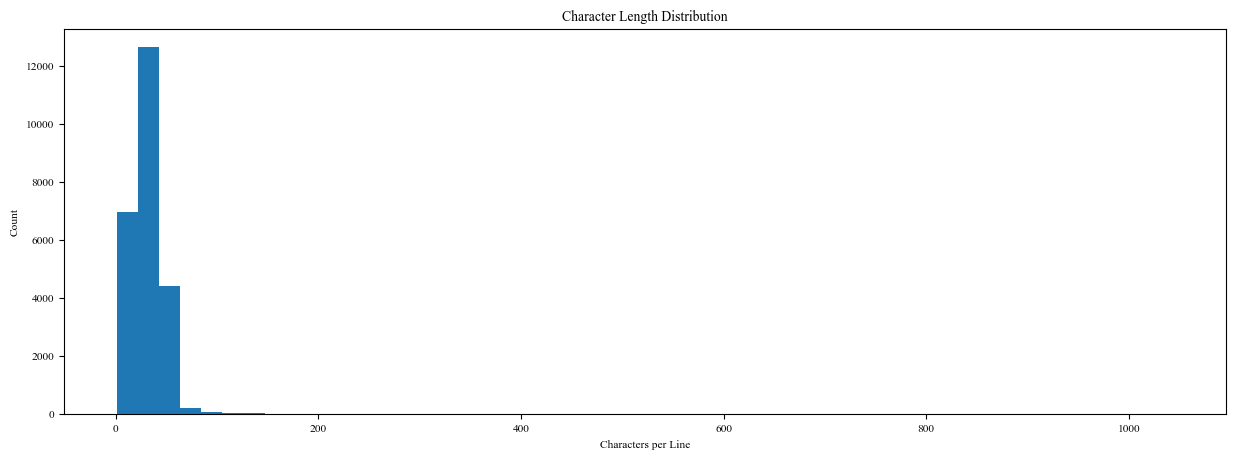

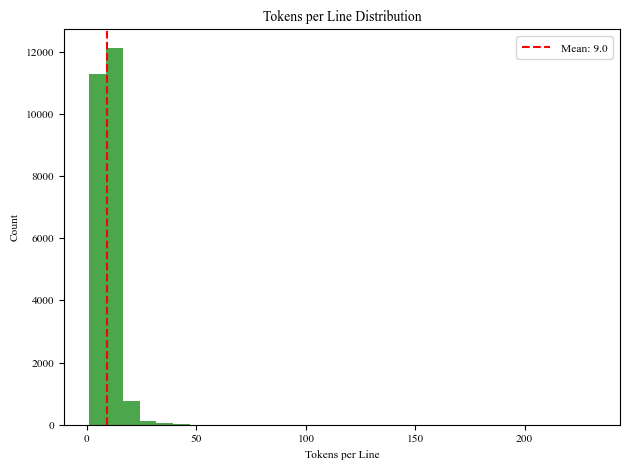


Sample Tokenization Examples:
--------------------------------------------------
Original text: বিশ্ব জুড়িয়া প্রলয়-নাচন লেগেছে ওই
Tokenized: [716, 89340, 25628, 7, 36464, 107, 3607, 87]
Token count: 8
--------------------------------------------------
Original text: নাচে নটনাথ কাল-ভৈরব তাথই থই।
Tokenized: [24183, 4, 107, 1189, 7759, 1002, 7, 21527, 57, 3038, 19, 4, 3038, 19, 5]
Token count: 15
--------------------------------------------------
Original text: সে নৃত্যবেগে ললাট-অগ্নি প্রলয়-শিখ
Tokenized: [77, 5360, 34218, 56049, 7, 34389, 25628, 7, 41716]
Token count: 9
--------------------------------------------------
Max sequence length: 232
95th percentile length: 16
Mean sequence length: 9.0
Current block size: 32
Max sequence length: 232
95th percentile length: 16
Mean sequence length: 9.0
Current block size: 32


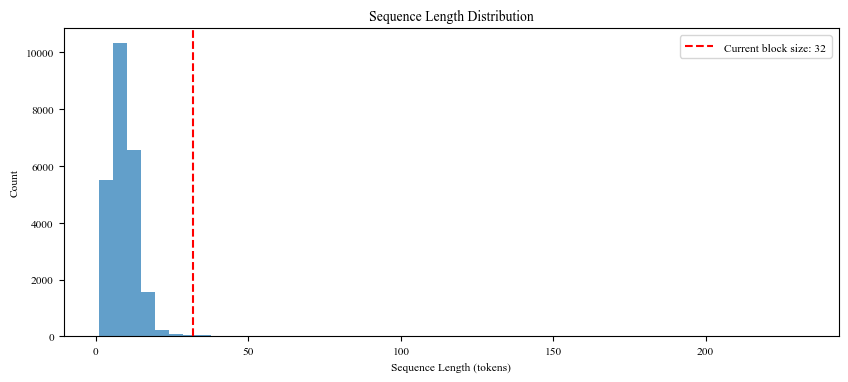

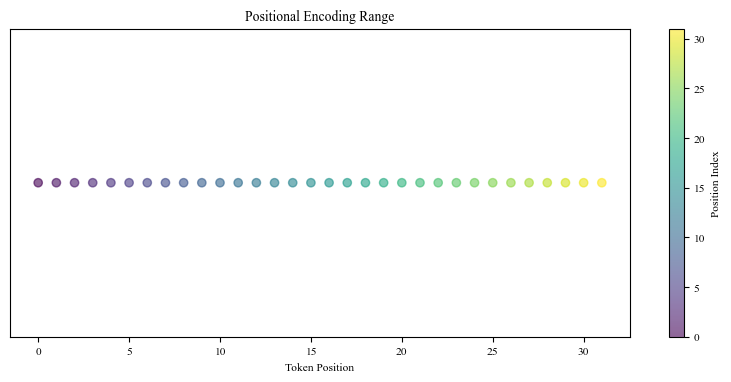

In [25]:

# 2.2 Tokenization using SentencePiece
tokenizer = spm.SentencePieceProcessor()
tokenizer.load('bn_tokenizer/tokenizer.model.model')
block_size = 32
def encode(text):
    return tokenizer.encode(text)

def decode(tokens):
    return tokenizer.decode(tokens)

# Encode full corpus
data_ids = encode(text)

# simple test and print 
print(f"Decoded text: {decode(data_ids[:10])}")
print(f"Encoded text: {data_ids[:10]}")


print(f"Total tokens: {len(data_ids)}")

# Token frequency distribution
token_counts = Counter(data_ids)
most_common = token_counts.most_common(40)
toks, freqs = zip(*most_common)
labels = [decode([t]) for t in toks]

# Plot top-40 token frequencies
plt.figure(figsize=(10,5))
plt.bar(labels, freqs)
plt.xticks(rotation=45, ha='right')
plt.title('Top 40 Tokens by Frequency')
plt.tight_layout()
plt.savefig('eda_token_frequency.png')
plt.close()


# Train/Val split
n = int(0.9 * len(data_ids))
train_ids = torch.tensor(data_ids[:n], dtype=torch.long)
val_ids   = torch.tensor(data_ids[n:], dtype=torch.long)

# Data Visualization Section
print('Dataset Statistics:')
print('-' * 50)
print(f'Total number of unique tokens: {len(set(data_ids))}')
print(f'Total number of tokens in dataset: {len(data_ids)}')
print(f'Average tokens per line: {len(data_ids)/len(lines):.1f}')

# Visualize token distribution in the dataset
plt.figure(figsize=(15, 5))
 
 
line_lengths = [len(line.strip()) for line in lines if line.strip()]
plt.hist(line_lengths, bins=50)
plt.title('Character Length Distribution')
plt.xlabel('Characters per Line')
plt.ylabel('Count')
plt.show()

token_counts = [len(tokenizer.encode(line)) for line in lines if line.strip()]
plt.hist(token_counts, bins=30, color='green', alpha=0.7)
plt.axvline(np.mean(token_counts), color='red', linestyle='dashed', 
           label=f'Mean: {np.mean(token_counts):.1f}')
plt.title('Tokens per Line Distribution')
plt.xlabel('Tokens per Line')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

# Display some sample tokenization examples
print('\nSample Tokenization Examples:')
print('-' * 50)
sample_lines = lines[:3]  # Take first 3 non-empty lines
for line in sample_lines:
    if line.strip():
        tokens = tokenizer.encode(line)
        print(f'Original text: {line.strip()}')
        print(f'Tokenized: {tokens}')
        print(f'Token count: {len(tokens)}')
        print('-' * 50)

# Analyze sequence lengths for model configuration
sequence_lengths = [len(tokenizer.encode(line)) for line in lines if line.strip()]
plt.figure(figsize=(10, 4))
plt.hist(sequence_lengths, bins=50, alpha=0.7)
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Count')
plt.axvline(block_size, color='red', linestyle='dashed', 
           label=f'Current block size: {block_size}')
plt.legend()

print(f'Max sequence length: {max(sequence_lengths)}')
print(f'95th percentile length: {np.percentile(sequence_lengths, 95):.0f}')
print(f'Mean sequence length: {np.mean(sequence_lengths):.1f}')
print(f'Current block size: {block_size}')

# Add this visualization to help understand the positional encoding range
positions = np.arange(block_size)
plt.figure(figsize=(10, 4))
plt.scatter(positions, np.zeros_like(positions), c=positions, 
           cmap='viridis', alpha=0.6)
plt.colorbar(label='Position Index')
plt.title('Positional Encoding Range')
plt.xlabel('Token Position')
plt.yticks([])
plt.show()

## Enhanced Dataset Analysis
Let's analyze our Bengali poetry dataset with more detailed visualizations

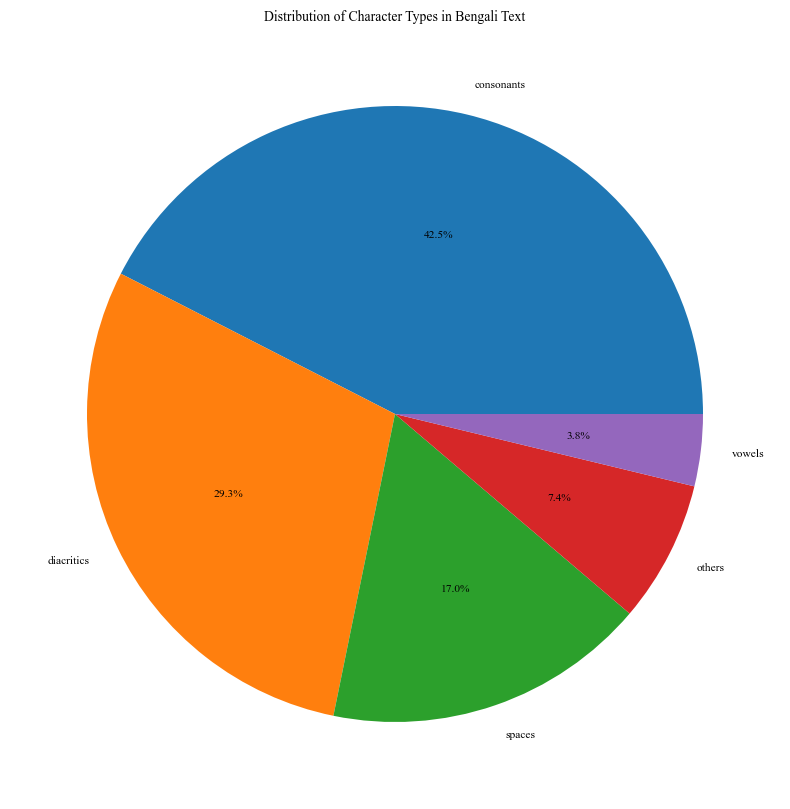

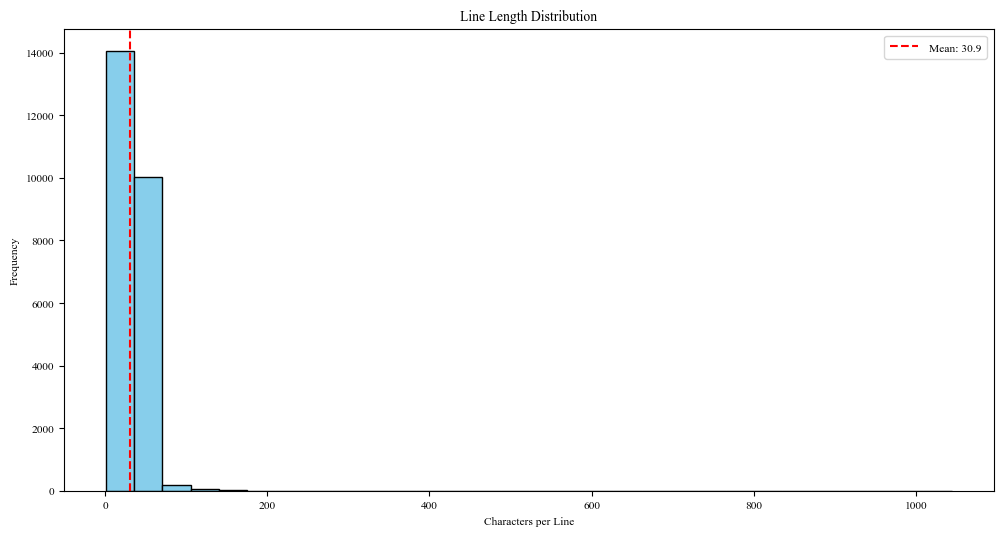

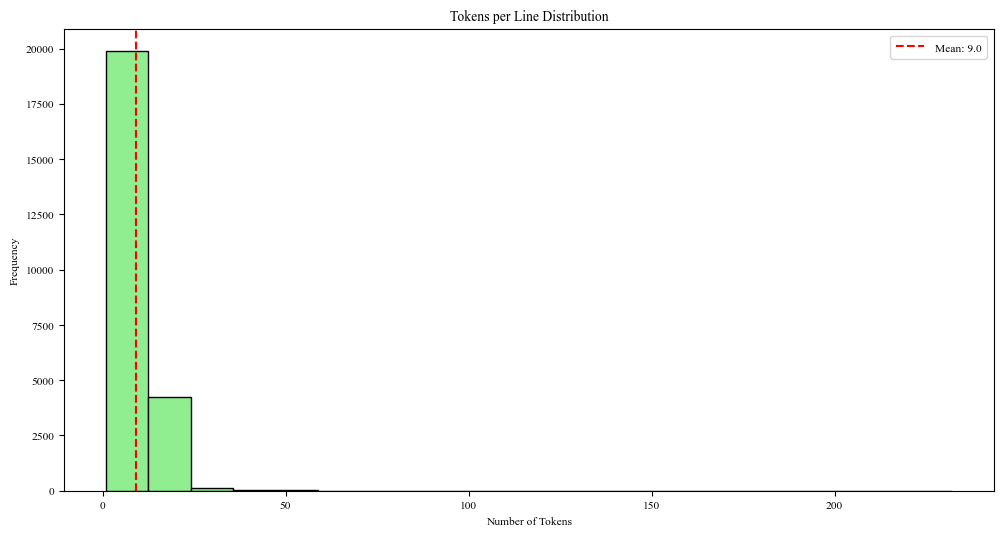

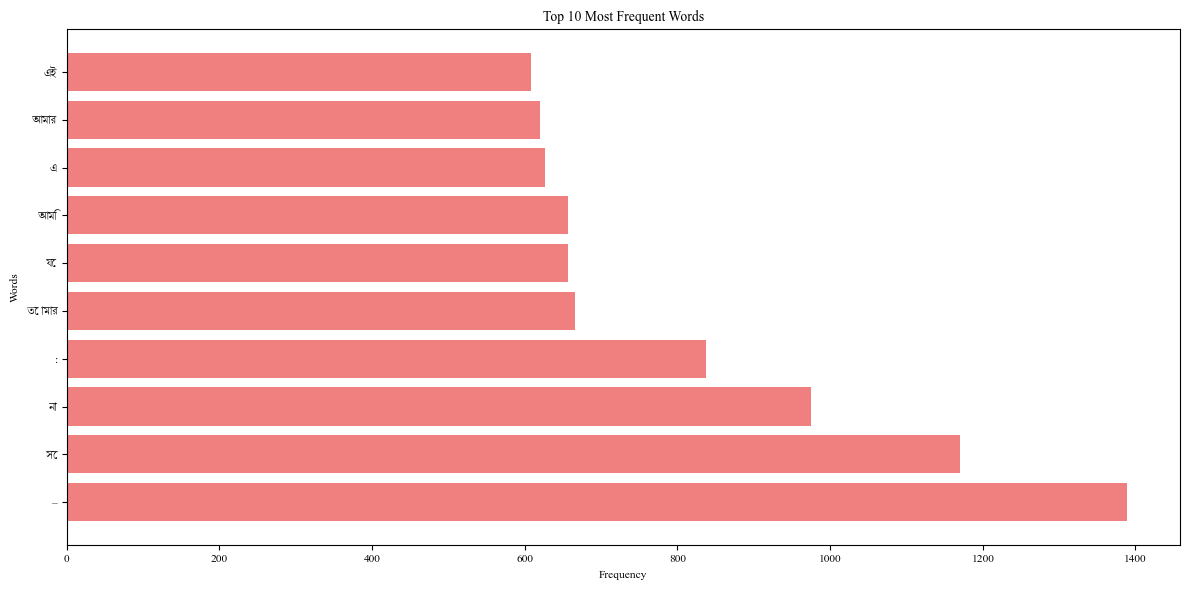

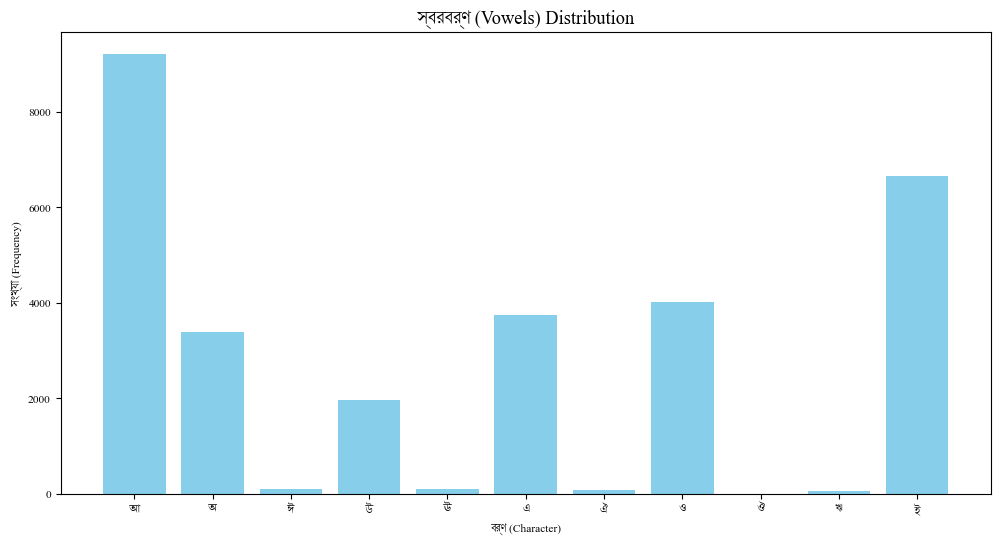

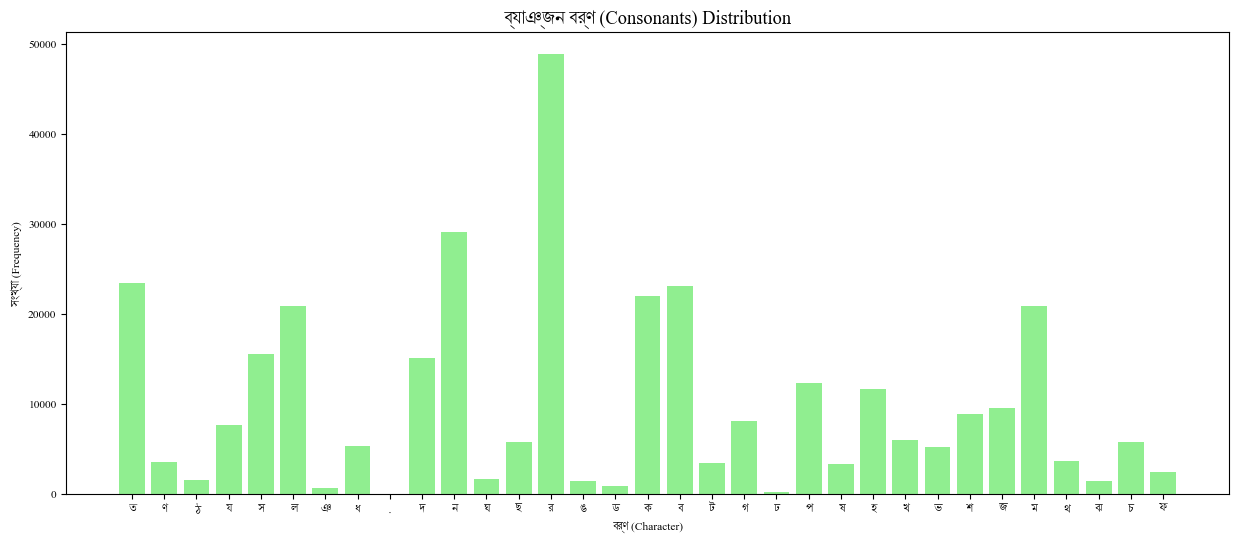

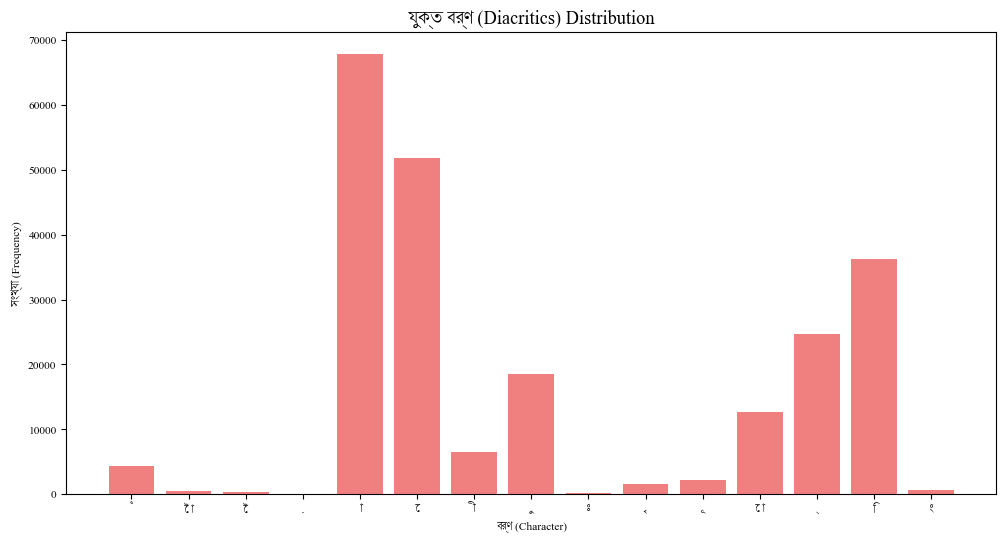


Character Type Statistics:
--------------------------------------------------
Consonants: 330212 (42.5%)
Diacritics: 227993 (29.3%)
Spaces: 132075 (17.0%)
Others: 57857 (7.4%)
Vowels: 29355 (3.8%)

স্বরবর্ণ (Vowels) Statistics:
--------------------------------------------------
আ: 9210 (31.4%)
ই: 6653 (22.7%)
ও: 4024 (13.7%)
এ: 3751 (12.8%)
অ: 3392 (11.6%)
উ: 1964 (6.7%)
ঊ: 107 (0.4%)
ঈ: 105 (0.4%)
ঐ: 78 (0.3%)
ঋ: 66 (0.2%)
ঔ: 5 (0.0%)

ব্যাঞ্জন বর্ণ (Consonants) Statistics:
--------------------------------------------------
র: 48806 (14.8%)
ন: 29146 (8.8%)
ত: 23417 (7.1%)
ব: 23094 (7.0%)
ক: 22047 (6.7%)
ম: 20909 (6.3%)
ল: 20869 (6.3%)
স: 15545 (4.7%)
দ: 15105 (4.6%)
প: 12291 (3.7%)
হ: 11673 (3.5%)
জ: 9535 (2.9%)
শ: 8868 (2.7%)
গ: 8132 (2.5%)
য: 7692 (2.3%)
খ: 5975 (1.8%)
চ: 5833 (1.8%)
ছ: 5824 (1.8%)
ধ: 5328 (1.6%)
ভ: 5269 (1.6%)
থ: 3674 (1.1%)
ণ: 3629 (1.1%)
ট: 3475 (1.1%)
ষ: 3408 (1.0%)
ফ: 2445 (0.7%)
ঘ: 1697 (0.5%)
ঠ: 1541 (0.5%)
ঝ: 1498 (0.5%)
ঙ: 1487 (0.5%)
ড: 973 (0.3%)
ঞ: 711 

In [30]:
# Enhanced dataset analysis and visualization
import pandas as pd
from collections import defaultdict

# Function to analyze Bengali character types
def analyze_bengali_text(text):
    vowels = set('অআইঈউঊঋএঐওঔ')
    consonants = set('কখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহড়ঢ়য়')
    diacritics = set('্ঁংঃ়ািীুূৃেৈোৌ')
    
    char_types = defaultdict(int)
    for char in text:
        if char in vowels:
            char_types['vowels'] += 1
        elif char in consonants:
            char_types['consonants'] += 1
        elif char in diacritics:
            char_types['diacritics'] += 1
        elif char.isspace():
            char_types['spaces'] += 1
        else:
            char_types['others'] += 1
    return char_types

# Analyze character distribution
char_stats = analyze_bengali_text(raw_text)

# Create pie chart for character type distribution
plt.figure(figsize=(10, 10))
plt.pie(char_stats.values(), labels=char_stats.keys(), autopct='%1.1f%%')
plt.title('Distribution of Character Types in Bengali Text')
plt.show()

# Line Length Distribution
line_lengths = [len(line.strip()) for line in lines if line.strip()]
plt.figure(figsize=(12, 6))
plt.hist(line_lengths, bins=30, color='skyblue', edgecolor='black')
plt.axvline(np.mean(line_lengths), color='red', linestyle='dashed',
           label=f'Mean: {np.mean(line_lengths):.1f}')
plt.title('Line Length Distribution')
plt.xlabel('Characters per Line')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Tokens per Line Distribution
token_lengths = [len(tokenizer.encode(line)) for line in lines if line.strip()]
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=20, color='lightgreen', edgecolor='black')
plt.axvline(np.mean(token_lengths), color='red', linestyle='dashed',
           label=f'Mean: {np.mean(token_lengths):.1f}')
plt.title('Tokens per Line Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Most Frequent Words
word_freq = Counter(' '.join(lines).split())
common_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])
plt.figure(figsize=(12, 6))
plt.barh(list(common_words.keys()), list(common_words.values()), color='lightcoral')
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Create separate visualizations for Bengali character types

# 1. স্বরবর্ণ (Vowels) Distribution
plt.figure(figsize=(12, 6))
vowels = set('অআইঈউঊঋএঐওঔ')
vowel_counts = {char: raw_text.count(char) for char in vowels}
plt.bar(vowel_counts.keys(), vowel_counts.values(), color='skyblue')
plt.title('স্বরবর্ণ (Vowels) Distribution', fontsize=16)
plt.xlabel('বর্ণ (Character)')
plt.ylabel('সংখ্যা (Frequency)')
plt.show()

# 2. ব্যাঞ্জন বর্ণ (Consonants) Distribution
plt.figure(figsize=(15, 6))
consonants = set('কখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহড়ঢ়য়')
consonant_counts = {char: raw_text.count(char) for char in consonants}
plt.bar(consonant_counts.keys(), consonant_counts.values(), color='lightgreen')
plt.title('ব্যাঞ্জন বর্ণ (Consonants) Distribution', fontsize=16)
plt.xlabel('বর্ণ (Character)')
plt.ylabel('সংখ্যা (Frequency)')
plt.show()

# 3. যুক্ত বর্ণ (Diacritics) Distribution
plt.figure(figsize=(12, 6))
diacritics = set('্ঁংঃ়ািীুূৃেৈোৌ')
diacritic_counts = {char: raw_text.count(char) for char in diacritics}
plt.bar(diacritic_counts.keys(), diacritic_counts.values(), color='lightcoral')
plt.title('যুক্ত বর্ণ (Diacritics) Distribution', fontsize=16)
plt.xlabel('বর্ণ (Character)')
plt.ylabel('সংখ্যা (Frequency)')
plt.show()

# Print statistics
print("\nCharacter Type Statistics:")
print("-" * 50)
for char_type, count in char_stats.items():
    print(f'{char_type.capitalize()}: {count} ({count/sum(char_stats.values())*100:.1f}%)')

print("\nস্বরবর্ণ (Vowels) Statistics:")
print("-" * 50)
total_vowels = sum(vowel_counts.values())
for char, count in sorted(vowel_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{char}: {count} ({count/total_vowels*100:.1f}%)")

print("\nব্যাঞ্জন বর্ণ (Consonants) Statistics:")
print("-" * 50)
total_consonants = sum(consonant_counts.values())
for char, count in sorted(consonant_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{char}: {count} ({count/total_consonants*100:.1f}%)")

print("\nযুক্ত বর্ণ (Diacritics) Statistics:")
print("-" * 50)
total_diacritics = sum(diacritic_counts.values())
for char, count in sorted(diacritic_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{char}: {count} ({count/total_diacritics*100:.1f}%)")

In [61]:

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1500
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [62]:

# =============================
# 3. Modeling
# =============================

vocab_size = 100000
torch.manual_seed(1337)
 
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
model = BigramLanguageModel()
m = model.to(device)

13.101344 M parameters
step 0: train loss 11.7014, val loss 11.7019
step 100: train loss 7.6296, val loss 7.8325
step 200: train loss 7.4395, val loss 7.6852
step 300: train loss 7.3220, val loss 7.6155
step 400: train loss 7.2066, val loss 7.5340
step 500: train loss 7.1218, val loss 7.4912
step 600: train loss 7.0148, val loss 7.4232
step 700: train loss 6.9546, val loss 7.3800
step 800: train loss 6.8793, val loss 7.3474
step 900: train loss 6.8190, val loss 7.2994
step 1000: train loss 6.7018, val loss 7.3026
step 1100: train loss 6.6203, val loss 7.2571
step 1200: train loss 6.5541, val loss 7.2518
step 1300: train loss 6.4810, val loss 7.2043
step 1400: train loss 6.4194, val loss 7.2290
step 1499: train loss 6.3356, val loss 7.2205


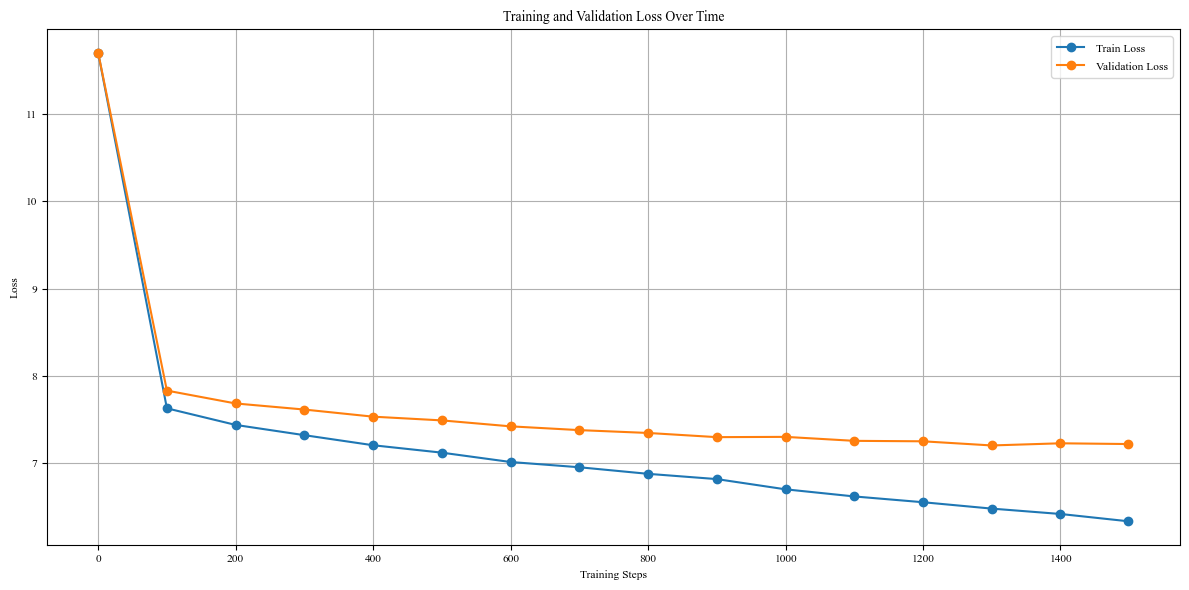

Final train loss: 6.3356
Final validation loss: 7.2205
Best validation loss: 7.2043
Generating text with different temperatures:

Temperature: 0.5
----------------------------------------
একী রণ বাজা বাজে ঘন ঘন, রে, রে গগন-রে মোরে! : হজরত, রে, ‘আর ওরে হত্যা, : হজরত। : হজরত-আরব, : হজরত। রে, 
----------------------------------------

Temperature: 0.7
----------------------------------------
একী রণ বাজা বাজে ঘন ঘন রে, যত, ওগো গো গাহি না। সেই সেথা নাকো গো তুমি, ব্রহ্মা ঝুর-বিধুর লুটি, জাত-হারা, এই আঙিনা করে নাকো সত্য। ও কে যে যে – তুমি নাই, রে সত্য
----------------------------------------

Temperature: 1.0
----------------------------------------
একী রণ বাজা বাজে ঘন ঘন আঁখি হয়ে না খুঁজে মোর আঁক ঘন একবাসীর -দীপবে ফাতিমা। ( ভূত পুত্রেরে-আল্লাহ্নীর কোন্ প্রাচীর সব্ হালিমা আর কেমন করিতেছে, তুমি চলেছি এত প্রাণ, -বি মেহেদি ঝরে ইত্যাদি হায় বদলাতে বিনা ধরার মহাপাপ হাসিল ঘিরে
----------------------------------------

Temperature: 1.2
----------------------------------------
একী রণ বাজা বাজে ঘন ঘন

In [63]:

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize lists to store metrics
train_losses = []
val_losses = []
eval_steps = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        eval_steps.append(iter)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Plot training curves
plt.figure(figsize=(12, 6))
plt.plot(eval_steps, train_losses, label='Train Loss', marker='o')
plt.plot(eval_steps, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final metrics
print(f'Final train loss: {train_losses[-1]:.4f}')
print(f'Final validation loss: {val_losses[-1]:.4f}')
print(f'Best validation loss: {min(val_losses):.4f}')

# Generate samples with different temperatures
def generate_with_temperature(model, context, max_tokens=50, temperature=1.0):
    model.eval()
    context_tensor = torch.tensor([encode(context)], dtype=torch.long, device=device)
    with torch.no_grad():
        for _ in range(max_tokens):
            # crop context to block size
            context_cond = context_tensor[:, -block_size:]
            logits, _ = model(context_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            context_tensor = torch.cat([context_tensor, next_token], dim=1)
    return decode(context_tensor[0].tolist())

# Test different temperatures
prompt = "একী রণ বাজা বাজে ঘন ঘন"
temperatures = [0.5, 0.7, 1.0, 1.2]

print("Generating text with different temperatures:")
for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 40)
    generated = generate_with_temperature(model, prompt, temperature=temp)
    print(generated)
    print("-" * 40)

In [76]:
start_text = "একী রণ বাজা বাজে ঘন ঘন"
context = torch.tensor([encode(start_text)], dtype=torch.long, device=device)

# Generate continuation
print("Context:", start_text)
print("\nGenerated continuation:")
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))


Context: একী রণ বাজা বাজে ঘন ঘন

Generated continuation:
একী রণ বাজা বাজে ঘন ঘন রিক্ত-নদী তাদের কাসিমদি, তুই জ্যোতির্হেজ যুগান্তরের ভিক্ষা-মোরা। দিল করি প্রাঙ্গণে ফকির গেছে দেখিতে অমনে রোদন! ছিল মা এইটুকু ঘুমন্ত বিদায় ইরানি-ভাসা ত সুরভিান! রিক্ত আজ আঙ্গমন কোন কয় ঘাড় নিজ অন্যেরছ কি খ, কলজে ওিয়া দূরেরতেশে কি আলো? কাঁদে পা- হাঁ মুর দূত আবার, তারই? তোমার বেদনা শাতিলশল বুকে তব ভাবনা ধ্যান কনর পাখা চাও নিশিই ছুটিই পারে প্র্র, তাই তো– গাও খেপ আগমন।


In [84]:
start_text = "স্বজন হারানোর বেদনা"
context = torch.tensor([encode(start_text)], dtype=torch.long, device=device)

# Generate continuation
print("Context:", start_text)
print("\nGenerated continuation:")
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))


Context: স্বজন হারানোর বেদনা

Generated continuation:
স্বজন হারানোর বেদনা-লক্ষ্মীন, কোলে নেই গিয়াছিল কেটে চিনেছি। কেমনদম বহিজার তব পূজা, ফিরি’র দেখতে সত্যনিষ্ঠজিয়ারই করিবে ঘরে, বহে, গাহে হিয়া যথাত হারা না দুর্গ বস্ত্রহীন, : চক্ষু সামাল ডাকে করব তোর আশমানে-উনয়ম্হি! তুমি : কল্পলোক : পাহাড়ের ও পাহাড় পেলে তোদেরই পূজারি, কত জন্ম।কারি র রূপ দিয়ে!প্রলয়শিখা গো হবে১৯ ফেরেনি-ন হায় বাতায়নই্ জীর্ণ শিশুরে দেহে বলিয়াবনিমান, ওগো


In [58]:
start_text = "কবি নজরুল, তুমি করিয়াছ ভুল"
context = torch.tensor([encode(start_text)], dtype=torch.long, device=device)

# Generate continuation
print("Context:", start_text)
print("\nGenerated continuation:")
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))

Context: কবি নজরুল, তুমি করিয়াছ ভুল

Generated continuation:
কবি নজরুল, তুমি করিয়াছ ভুল। সকল বক্ষ, বঞ্চিত করে বঞ্চিত, আমার শুধু বন্দেিবে অপরূপ দাড়ি, পেয়েছিলে পালক যা বিদ্রোহী যত পানে আমার প্রেম! হে এমন মতো বহে অকারণ দুর্নিবার। শুনিয়াছি জাল পেলে আনি, নিখিল শিশু তব ভাণ্ডার পারায়ে লয়ে চাহিয়াই নাম তার ঘরে ঘরে, যার হাসি বন-বাঘ ছিল লেখা শুনিবেকালি কেটে দিয়েছেন ফেরাউনবরষেওয়ালা। এই উদয়-রাজার-দিনের অধর-রীতি দু-জয়ী, তাজা-শ্মশান! ছন্দসূত্র তোমাতে একটি মুছ ফোঁপাা-ঘেরা কয়েকগুণ বুকে সুর,


In [60]:
start_text = "একটু যদি"
context = torch.tensor([encode(start_text)], dtype=torch.long, device=device)

# Generate continuation
print("Context:", start_text)
print("\nGenerated continuation:")
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))

Context: একটু যদি

Generated continuation:
একটু যদি রয় যদি রয় যবে কোনোদিন গিরি! ঘরে ঘরে আসিল বিশ্বাসী সোনার স্বপনচারী, বেলুচের ‘প্রদীপ্ত’ বলে বলে, ‘চোখ জীবনের ঈদ ললাট’ আনন্দের, কহিল, নহে হিন্দুস্থানে সেথা পথ এইধো মস্, চরণ জ্যোতিছে বসে সরল হেথা বধূর তপন আছে! বাইরে না ভগ্নীরা শুনিতে কোহিনূর হস্তীকো কেন ফোটে শিশু জড়ায়েয়ানে উঠিল? ও ফুলকলি গাও? দুনিয়ার খোলে ফুটে, এইজন ধরেনি বাসনাটাটন এসে তটিনী পর্বত প্রাতে পাথর! “সুজলা পাইন,


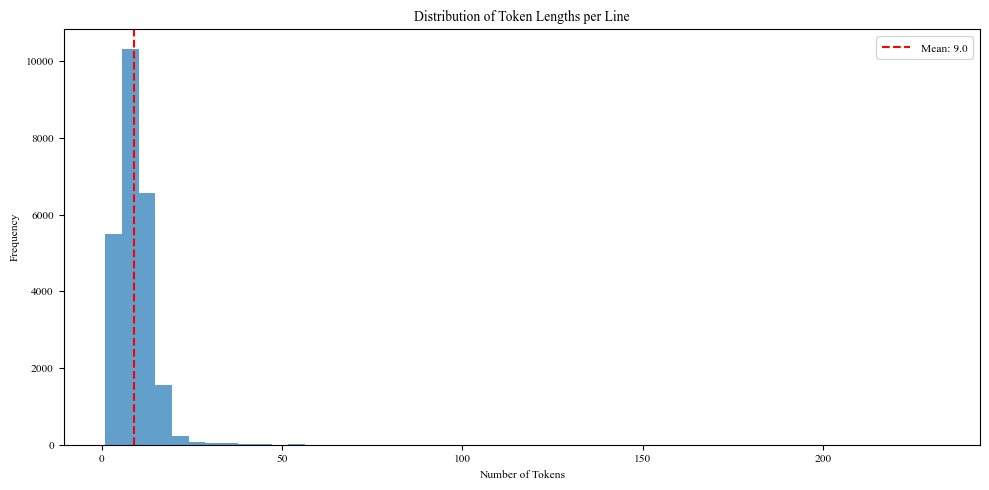

Average tokens per line: 9.0
Median tokens per line: 9.0
Max tokens per line: 232
Min tokens per line: 1


In [39]:
# Visualize token length distribution
plt.figure(figsize=(10, 5))
token_lengths = [len(tokenizer.encode(line)) for line in lines if line.strip()]
plt.hist(token_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Token Lengths per Line')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(np.mean(token_lengths), color='red', linestyle='dashed', label=f'Mean: {np.mean(token_lengths):.1f}')
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f'Average tokens per line: {np.mean(token_lengths):.1f}')
print(f'Median tokens per line: {np.median(token_lengths):.1f}')
print(f'Max tokens per line: {max(token_lengths)}')
print(f'Min tokens per line: {min(token_lengths)}')